In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
def trim_dataset(df):
    # Adding column names to the data
    df.columns = ['Data']
    
    #  Finding the derivative at each point so we can analyze where the data starts changing
    df['Derivative'] = df['Data'].diff()
    
    # Since there is so much deviation in the derivatives, we can find which ones are statistically significant with z-scores
    z_scores = (df['Derivative'] - df['Derivative'].mean()) / df['Derivative'].std()
    
    # Anything more than 3 standard deviations away from the mean will be considered significant 
    z_scores_threshold = 3
    
    # Data structure with all the statistically significant derivatives
    exceptionally_high_indices = df[z_scores > z_scores_threshold].index
    
    end_index = exceptionally_high_indices[-1] + 50 # Some tolerance
    start_index = exceptionally_high_indices[0] - 50 # Some tolerance
        
    # Trim the data
    useful_data = df.loc[start_index:end_index]
    
    return useful_data

In [308]:
def apply_moving_median_filter(df):
    # Naming column; look into actually naming the data when collecting in the future 💀
    df.columns = ['Voltage']

    # Define window size as a percentage of the data length
    window_percentage = 0.1  # Adjust this value as needed
    window_size = int(len(df) * window_percentage)
    if window_size % 2 == 0:  # Ensure window size is odd for median calculation
        window_size += 1

    # Apply the moving median
    df['Smoothed_Voltage'] = df['Voltage'].rolling(window=window_size, center=True).median()

    # Drop NaN values created by the rolling operation at the edges
    df.dropna(inplace=True)

    return df


In [309]:
def get_voltages_from_calibration_data(df):
    
    window_size = 50 # Checking every 50 values for flatness
    median_indices = []

    df['Derivative'] = df['Smoothed_Voltage'].diff()

    for i in range(0, len(df), window_size):
        window = df['Derivative'].iloc[i:i+window_size]
        if all(window == 0):
            median_index = (i + i + window_size - 1) // 2  # Calculate the median index
            median_indices.append(median_index)
    
    new_df = pd.DataFrame({'Median_Index': median_indices, 'Smoothed_Voltage': df['Smoothed_Voltage'].iloc[median_indices]})

    differences = new_df['Smoothed_Voltage'].diff()

    # Define a threshold for considering a region as a plateau
    threshold = 10  

    # Find the plateaus
    plateau_regions = []
    start_idx = None

    for i, diff in enumerate(differences):
        if abs(diff) > threshold:
            if start_idx is not None:
                plateau_regions.append((median_indices[start_idx], median_indices[i - 1]))
                start_idx = None
        elif start_idx is None:
            start_idx = i

    # Handle the last plateau
    if start_idx is not None:
        plateau_regions.append((median_indices[start_idx], median_indices[-1]))

    median_values = []

    for start, end in plateau_regions:
        # Take the median of the corresponding range in the 'Smoothed_Voltage' column
        median_value = df['Voltage'].iloc[start:end+1].median()
        median_values.append(median_value)

    return median_values

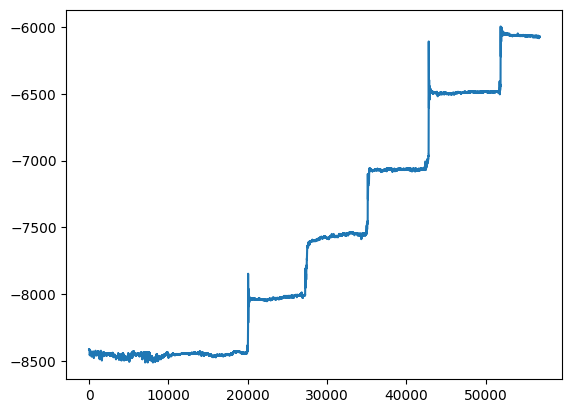

In [310]:
calibration_df = pd.read_csv(r'All_Data\2022_2023_Data\Calibration1.csv')
plt.plot(calibration_df.index, calibration_df)
plt.show()

In [311]:
calibration_df = apply_moving_median_filter(calibration_df)
get_voltages_from_calibration_data(calibration_df)

[-8452.148438,
 -8032.226562,
 -7563.476562,
 -7065.429688,
 -6489.257812,
 -6059.570312]

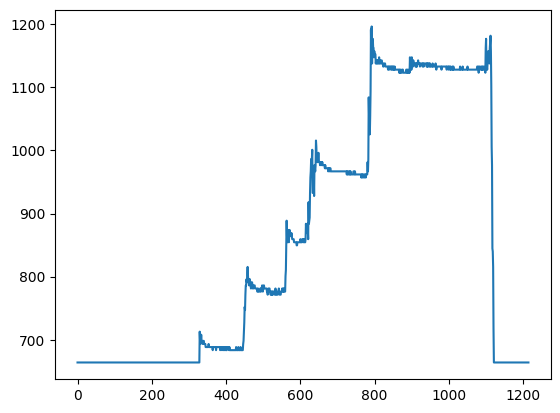

In [312]:
calibration_df_1 = pd.read_csv(r'All_Data\2023_Testing_Data\20221210_Calibration1.csv')
plt.plot(calibration_df_1.index, calibration_df_1)
plt.show()

In [313]:
calibration_df_1 = apply_moving_median_filter(calibration_df_1)



[664.0625, 961.914062, 1132.8125]

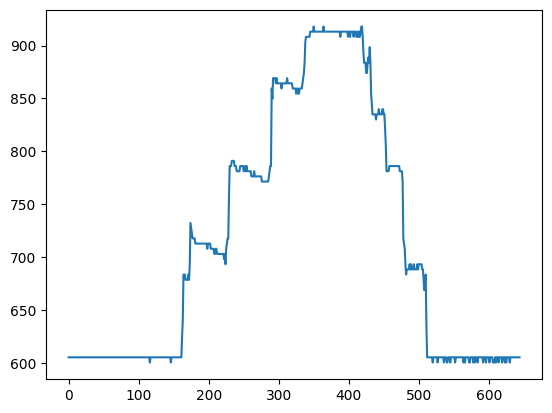

In [315]:
calibration_df_2 = pd.read_csv(r'All_Data\Raw\5-07-22_Test_Fire_Calibration_2_Raw.csv')
plt.plot(calibration_df_2.index, calibration_df_2)
plt.show()

In [316]:
calibration_df_2 = apply_moving_median_filter(calibration_df_2)
get_voltages_from_calibration_data(calibration_df_2)

[727.539062]

In [15]:
calibration_df_3 = pd.read_csv("All_Data/Raw/Calibration_Data_Raw.csv")
calibration_df_3 = pd.DataFrame(calibration_df_3.iloc[:,0])
calibration_df_3

,664.0625
0,664.062500
1,664.062500
2,664.062500
3,664.062500
4,664.062500
...,...
53690,659.179688
53691,659.179688
53692,654.296875
53693,659.179688


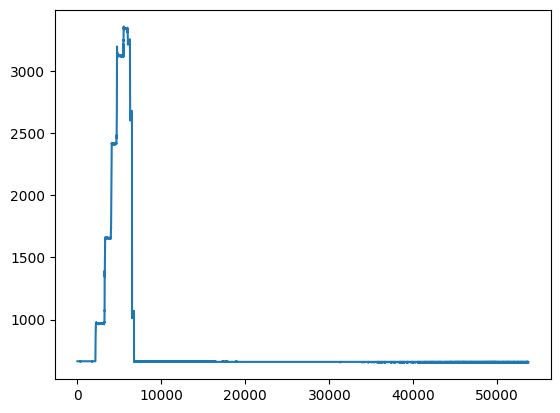

In [7]:
plt.plot(calibration_df_3.index, calibration_df_3['Data'])
plt.show()

In [16]:
calibration_df_3_trim = trim_dataset(calibration_df_3)

calibration_df_3_trim

,Data,Derivative
2096,664.062500,0.0
2097,664.062500,0.0
2098,664.062500,0.0
2099,664.062500,0.0
2100,664.062500,0.0
...,...,...
6562,1059.570312,0.0
6563,1059.570312,0.0
6564,1059.570312,0.0
6565,1059.570312,0.0


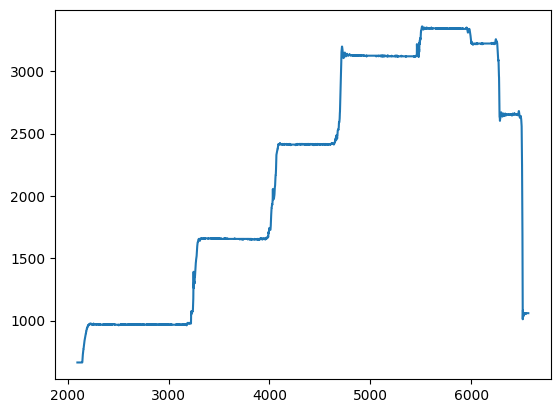

In [17]:
plt.plot(calibration_df_3_trim.index, calibration_df_3_trim['Data'])
plt.show()